In [32]:
import requests
import pandas as pd
from datetime import date

from sklearn.ensemble import RandomForestClassifier


def load_data(*args, **kwargs):
    """
    Load EPL match outcomes from Premier League API.

    """

    season = 2025
    past_years = 5
    start_matchweek = 1
    end_matchweek = 38

    all_matches = []
    all_standings = []

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }


    for year in range(past_years):
        standings_url = f"https://sdp-prem-prod.premier-league-prod.pulselive.com/api/v5/competitions/8/seasons/{season-year}/standings?live=false"

        try:
            response = requests.get(standings_url, headers=headers, timeout=10)

            if response.status_code != 200:
                print(f"Standings {year}: Error {response.status_code}")
                continue

            standings = response.json()
            season_label = standings.get("season", {}).get("id", str(year))
            for entry in standings["tables"][0].get("entries", []):
                team = entry.get("team", {}).get("name")
                points = entry.get("overall", {}).get("points")
                position = entry.get("overall", {}).get("position")
                played = entry.get("overall", {}).get("played")
                home_won = entry.get("home", {}).get("won")
                home_lost = entry.get("home", {}).get("lost")
                home_drawn = entry.get("home", {}).get("drawn")
                home_goals_for = entry.get("home", {}).get("goalsFor")
                home_goals_against = entry.get("home", {}).get("goalsAgainst")
                away_won = entry.get("away", {}).get("won")
                away_lost = entry.get("away", {}).get("lost")
                away_drawn = entry.get("away", {}).get("drawn")
                away_goals_for = entry.get("away", {}).get("goalsFor")
                away_goals_against = entry.get("away", {}).get("goalsAgainst")
                all_standings.append({
                    "season": season_label,
                    "position": position,
                    "team": team,
                    "points": points,
                    "played": played,
                    "home.won": home_won,
                    "home.lost": home_lost,
                    "home.drawn": home_drawn,
                    "home.goals_for": home_goals_for,
                    "home.goals_against": home_goals_against,
                    "away.won": away_won,
                    "away.lost": away_lost,
                    "away.drawn": away_drawn,
                    "away.goals_for": away_goals_for,
                    "away.goals_against": away_goals_against,
                })

        except Exception as e:
            print(f"Standings {year}: Error - {str(e)}")
            continue

        if season - year == season:
            season_2025_start_date = date(2025, 8, 15)
            actual_date = date(2025,10,20)
            end_matchweek = round((actual_date - season_2025_start_date).days / 7) - 1
        else:
            end_matchweek = 38

        for matchweek in range(start_matchweek, end_matchweek + 1):
            matches_url = f"https://sdp-prem-prod.premier-league-prod.pulselive.com/api/v1/competitions/8/seasons/{season-year}/matchweeks/{matchweek}/matches"

            try:
                response = requests.get(matches_url, headers=headers, timeout=10)

                if response.status_code != 200:
                    print(f"Matchweek {matchweek}: Error {response.status_code}")
                    continue

                data = response.json()
                matches_data = data.get('data', [])

                for match in matches_data:
                    try:
                        home_team = match.get('homeTeam', {})
                        away_team = match.get('awayTeam', {})

                        match_info = {
                            'match_id': match.get('matchId'),
                            'matchweek': matchweek,
                            'season': season-year,
                            'kickoff': match.get('kickoff'),
                            'kickoff_timezone': match.get('kickoffTimezone'),
                            'period': match.get('period'),
                            'competition': match.get('competition'),
                            'venue': match.get('ground'),
                            'attendance': match.get('attendance'),
                            'clock': match.get('clock'),
                            'result_type': match.get('resultType'),

                            # Home team info
                            'home_team': home_team.get('name'),
                            'home_team_id': home_team.get('id'),
                            'home_team_short': home_team.get('shortName'),
                            'home_score': home_team.get('score'),
                            'home_half_time_score': home_team.get('halfTimeScore'),
                            'home_red_cards': home_team.get('redCards'),

                            # Away team info
                            'away_team': away_team.get('name'),
                            'away_team_id': away_team.get('id'),
                            'away_team_short': away_team.get('shortName'),
                            'away_score': away_team.get('score'),
                            'away_half_time_score': away_team.get('halfTimeScore'),
                            'away_red_cards': away_team.get('redCards'),
                        }

                        # Determine match outcome
                        home_score = match_info['home_score']
                        away_score = match_info['away_score']

                        if home_score is not None and away_score is not None:
                            if home_score > away_score:
                                match_info['outcome'] = 'H'  # Home win
                                match_info['winner'] = match_info['home_team']
                            elif home_score < away_score:
                                match_info['outcome'] = 'A'  # Away win
                                match_info['winner'] = match_info['away_team']
                            else:
                                match_info['outcome'] = 'D'  # Draw
                                match_info['winner'] = 'Draw'
                            all_matches.append(match_info)

                    except Exception as e:
                        print(f"Error processing match in matchweek {matchweek}: {str(e)}")
                        continue

            except Exception as e:
                print(f"Matchweek {matchweek}: Error - {str(e)}")
                continue

    matches_df = pd.DataFrame(all_matches)

    # Convert kickoff to datetime
    if 'kickoff' in matches_df.columns and len(matches_df) > 0:
        matches_df['kickoff_datetime'] = pd.to_datetime(matches_df['kickoff'], errors='coerce')

    print(f"\n✓ Successfully loaded {len(matches_df)} matches from matchweeks {start_matchweek}-{end_matchweek}")
    if len(matches_df) > 0:
        print(f"\nSample data:")
        print(matches_df[['matchweek', 'home_team', 'away_team', 'home_score', 'away_score', 'outcome']].head(5))

    standings_df = pd.DataFrame(all_standings)

    return matches_df, standings_df

In [33]:
  m,s = load_data()


✓ Successfully loaded 1599 matches from matchweeks 1-38

Sample data:
   matchweek                 home_team         away_team  home_score  \
0          1                 Liverpool       Bournemouth           4   
1          1               Aston Villa  Newcastle United           0   
2          1  Brighton and Hove Albion            Fulham           1   
3          1         Nottingham Forest         Brentford           3   
4          1                Sunderland   West Ham United           3   

   away_score outcome  
0           2       H  
1           0       D  
2           1       D  
3           1       H  
4           0       H  


In [34]:
s

,season,position,team,points,played,home.won,home.lost,home.drawn,home.goals_for,home.goals_against,away.won,away.lost,away.drawn,away.goals_for,away.goals_against
0,2025,1,Arsenal,19,8,3,0,1,11,1,3,1,0,4,2
1,2025,2,Manchester City,16,8,3,1,0,10,3,2,1,1,7,3
2,2025,3,Bournemouth,15,8,3,0,1,6,2,1,1,2,8,9
3,2025,4,Liverpool,15,8,3,1,0,8,5,2,2,0,6,6
4,2025,5,Chelsea,14,8,2,1,1,5,4,2,1,1,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021,16,Everton,39,38,9,8,2,27,25,2,13,4,16,41
96,2021,17,Leeds United,38,38,4,9,6,19,38,5,9,5,23,41
97,2021,18,Burnley,35,38,5,8,6,18,25,2,9,8,16,28
98,2021,19,Watford,23,38,2,15,2,17,46,4,12,3,17,31


In [35]:
m

,match_id,matchweek,season,kickoff,kickoff_timezone,period,competition,venue,attendance,clock,...,home_red_cards,away_team,away_team_id,away_team_short,away_score,away_half_time_score,away_red_cards,outcome,winner,kickoff_datetime
0,2561895,1,2025,2025-08-15 20:00:00,BST,FullTime,Premier League,"Anfield, Liverpool",60315.0,97,...,0,Bournemouth,91,Bournemouth,2,0,0,H,Liverpool,2025-08-15 20:00:00
1,2561896,1,2025,2025-08-16 12:30:00,BST,FullTime,Premier League,"Villa Park, Birmingham",42526.0,97,...,1,Newcastle United,4,Newcastle,0,0,0,D,Draw,2025-08-16 12:30:00
2,2561897,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"American Express Stadium, Falmer",31478.0,98,...,0,Fulham,54,Fulham,1,0,0,D,Draw,2025-08-16 15:00:00
3,2561898,1,2025,2025-08-17 14:00:00,BST,FullTime,Premier League,"The City Ground, Nottingham",29949.0,96,...,0,Brentford,94,Brentford,1,0,0,H,Nottingham Forest,2025-08-17 14:00:00
4,2561899,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"Stadium of Light, Sunderland",46233.0,98,...,0,West Ham United,21,West Ham,0,0,0,H,Sunderland,2025-08-16 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,2210646,38,2021,2022-05-22 16:00:00,BST,FullTime,Premier League,"Selhurst Park, London",25434.0,97,...,0,Manchester United,1,Man Utd,0,0,0,H,Crystal Palace,2022-05-22 16:00:00
1595,2210647,38,2021,2022-05-22 16:00:00,BST,FullTime,Premier League,"King Power Stadium, Leicester",32003.0,97,...,0,Southampton,20,Southampton,1,0,0,H,Leicester City,2022-05-22 16:00:00
1596,2210648,38,2021,2022-05-22 16:00:00,BST,FullTime,Premier League,"Anfield, Liverpool",53097.0,94,...,0,Wolverhampton Wanderers,39,Wolves,1,1,0,H,Liverpool,2022-05-22 16:00:00
1597,2210649,38,2021,2022-05-22 16:00:00,BST,FullTime,Premier League,"Etihad Stadium, Manchester",53395.0,95,...,0,Aston Villa,7,Aston Villa,2,1,0,H,Manchester City,2022-05-22 16:00:00


In [36]:


print("\n--- Basic Info ---")
print(m.info())

print("\n--- Sample Data ---")
print(m.head())

print("\n--- Missing Values ---")
print(m.isna().sum())

print("\n--- Duplicate Rows ---")
print(m.duplicated().sum())

print("\n--- Data Type Summary ---")
print(m.dtypes)

print("\n--- Numeric Range Checks ---")
print("Attendance < 0:", (m['attendance'] < 0).sum())
print("Goals negative:", ((m['away_score'] < 0) | (m['home_score'] < 0)).sum())
print("Home Halftime Goals > Home Goals :", (m['home_half_time_score'] > m['home_score']).sum())
print("Away Halftime Goals > Away Goals :", (m['away_half_time_score'] > m['away_score']).sum())
print("Home Redcards < 0 :", (m['home_red_cards'] < 0).sum())
print("Away Redcards < 0 :", (m['away_red_cards'] < 0).sum())

print("\n--- Logical Checks ---")
def winner_correct(row):
    if row['outcome'] == 'H' and row['winner'] != row['home_team']:
        return False
    elif row['outcome'] == 'A' and row['winner'] != row['away_team']:
        return False
    elif row['outcome'] == 'D' and row['winner'] != 'Draw':
        return False
    return True

logic_issues = m.apply(lambda r: not winner_correct(r), axis=1).sum()
print(f"Rows with mismatched Winner/Outcome: {logic_issues}")
print("Missing matches:", 10 - len(m) % 10)

print("\n--- Attendance Outliers ---")
q1 = m['attendance'].quantile(0.25)
q3 = m['attendance'].quantile(0.75)
iqr = q3 - q1
outliers = m[(m['attendance'] < (q1 - 1.5 * iqr)) | (m['attendance'] > (q3 + 1.5 * iqr))]
print(f"Outlier count: {len(outliers)}")

summary = {
    "rows": len(m),
    "columns": len(m.columns),
    "missing_values": m.isna().sum().sum(),
    "duplicates": m.duplicated().sum(),
    "logical_issues": logic_issues,
    "attendance_outliers": len(outliers)
}
print("\n--- Summary ---")
for k, v in summary.items():
    print(f"{k}: {v}")



--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   match_id              1599 non-null   object        
 1   matchweek             1599 non-null   int64         
 2   season                1599 non-null   int64         
 3   kickoff               1599 non-null   object        
 4   kickoff_timezone      1599 non-null   object        
 5   period                1599 non-null   object        
 6   competition           1599 non-null   object        
 7   venue                 1599 non-null   object        
 8   attendance            1581 non-null   float64       
 9   clock                 1599 non-null   object        
 10  result_type           1599 non-null   object        
 11  home_team             1599 non-null   object        
 12  home_team_id          1599 non-null   object        
 13

In [51]:
m['clock'] = m['clock'].astype(int)
m['away_team_id'] = m['away_team_id'].astype(int)
m['home_team_id'] = m['home_team_id'].astype(int)
print(m.dtypes)

match_id                        object
matchweek                        int64
season                           int64
kickoff                         object
kickoff_timezone                object
period                          object
competition                     object
venue                           object
attendance                     float64
clock                            int64
result_type                     object
home_team                       object
home_team_id                     int64
home_team_short                 object
home_score                       int64
home_half_time_score             int64
home_red_cards                   int64
away_team                       object
away_team_id                     int64
away_team_short                 object
away_score                       int64
away_half_time_score             int64
away_red_cards                   int64
outcome                         object
winner                          object
kickoff_datetime        d

In [54]:
mean_attendance = m['attendance'].median()
m['attendance'].fillna(mean_attendance, inplace=True)
print(m.isna().sum())

match_id                0
matchweek               0
season                  0
kickoff                 0
kickoff_timezone        0
period                  0
competition             0
venue                   0
attendance              0
clock                   0
result_type             0
home_team               0
home_team_id            0
home_team_short         0
home_score              0
home_half_time_score    0
home_red_cards          0
away_team               0
away_team_id            0
away_team_short         0
away_score              0
away_half_time_score    0
away_red_cards          0
outcome                 0
winner                  0
kickoff_datetime        0
dtype: int64


/var/folders/_s/bx5zry710zvdx70b0np94tdm0000gn/T/ipykernel_1127/2000976.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  m['attendance'].fillna(mean_attendance, inplace=True)


In [109]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

TRAIN_SEASONS = list(range(2021, 2025))
PREDICT_SEASON = 2025
ELO_K = 20
ELO_HOME_ADV = 60
ROLLING_WINDOW = 5
RANDOM_STATE = 42

def init_elo(teams, base=1500):
    return {t: base for t in teams}

def expected_score(elo_ta, elo_th):
    return 1 / (1 + 10 ** ((elo_ta - elo_th) / 400.0))

def compute_elo_ratings(df):
    """
    Compute per-match pre-game ELO ratings for home and away teams.
    Returns two new columns: elo_home_pre, elo_away_pre
    """

    team_col_home='home_team'
    team_col_away='away_team'
    score_home='home_score'
    score_away='away_score'
    season_order_col='kickoff_datetime'

    teams = pd.concat([df[team_col_home], df[team_col_away]]).unique()
    elo = init_elo(teams)
    elo_home_pre = []
    elo_away_pre = []

    df_sorted = df.sort_values(by=season_order_col).reset_index(drop=True)
    for _, row in df_sorted.iterrows():
        th = row[team_col_home]
        ta = row[team_col_away]
        elo_home_pre.append(elo[th])
        elo_away_pre.append(elo[ta])

        # compute outcome
        if row[score_home] > row[score_away]:
            s_h, s_a = 1.0, 0.0
        elif row[score_home] < row[score_away]:
            s_h, s_a = 0.0, 1.0
        else:
            s_h, s_a = 0.5, 0.5

        exp_h = expected_score(elo[ta], elo[th])
        exp_a = 1-exp_h

        elo[th] = elo[th] + ELO_K * (s_h - exp_h)
        elo[ta] = elo[ta] + ELO_K * (s_a - exp_a)

    # attach to original index
    df_out = df_sorted.copy()
    df_out['elo_home_pre'] = elo_home_pre
    df_out['elo_away_pre'] = elo_away_pre
    return df_out.sort_index()  # put back in original order

def predict(df):

    df = df.rename(columns={ 'winner': 'winner_label', 'outcome': 'outcome_label' }) if 'winner' in df.columns else df

    df = compute_elo_ratings(df)

    df['home_adv'] = 1
    df['goal_diff_pre'] = df['elo_home_pre'] - df['elo_away_pre']
    df['kickoff_dayofweek'] = df['kickoff_datetime'].dt.weekday
    df['kickoff_hour'] = df['kickoff_datetime'].dt.hour

    home_rows = df[['match_id','kickoff_datetime','season','home_team','away_team','home_score','away_score']].copy()
    home_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    home_rows['is_home'] = 1
    away_rows = df[['match_id','kickoff_datetime','season','away_team','home_team','away_score','home_score']].copy()
    away_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    away_rows['is_home'] = 0
    team_rows = pd.concat([home_rows, away_rows], ignore_index=True)

    team_rows = team_rows.sort_values(['team','kickoff_datetime'])

    team_rows['points'] = team_rows.apply(lambda r: 3 if r['score_for']>r['score_against'] else (1 if r['score_for']==r['score_against'] else 0), axis=1)
    team_rows[['gf_roll','ga_roll','pts_roll']] = team_rows.groupby('team')[['score_for','score_against','points']].rolling(window=ROLLING_WINDOW, min_periods=1).mean().reset_index(level=0, drop=True)[['score_for','score_against','points']]

    # take last pre-match rolling values for home and away
    team_rows = team_rows.sort_values(['match_id','team','kickoff_datetime']).drop_duplicates(subset=['match_id','team'], keep='last')
    home_features = team_rows[team_rows['is_home']==1][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'home_{c}' if c!='match_id' else c)
    away_features = team_rows[team_rows['is_home']==0][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'away_{c}' if c!='match_id' else c)
    df = df.merge(home_features, on='match_id', how='left').merge(away_features, on='match_id', how='left')

    df = df.sort_values('kickoff_datetime').reset_index(drop=True)
    h2h_home_wins = []
    h2h_away_wins = []
    h2h_draws = []
    h2h_hist = {}
    for _, row in df.iterrows():
        key = tuple(sorted([row['home_team'], row['away_team']]))
        hist = h2h_hist.get(key, {'home_w':0,'away_w':0,'draw':0,'matches':0})
        h2h_home_wins.append(hist['home_w'])
        h2h_away_wins.append(hist['away_w'])
        h2h_draws.append(hist['draw'])
        # update hist with this match result (home/away relative to original home)
        if row['home_score'] > row['away_score']:
            hist['home_w'] += 1
        elif row['home_score'] < row['away_score']:
            hist['away_w'] += 1
        else:
            hist['draw'] += 1
        hist['matches'] += 1
        h2h_hist[key] = hist
    df['h2h_home_wins_prior'] = h2h_home_wins
    df['h2h_away_wins_prior'] = h2h_away_wins
    df['h2h_draws_prior'] = h2h_draws

    last_kickoff = {}
    rest_days_home = []
    rest_days_away = []
    for _, row in df.iterrows():
        th = row['home_team']; ta = row['away_team']; t0 = row['kickoff_datetime']

        if th in last_kickoff:
            delta = (t0 - last_kickoff[th]).total_seconds() / (24*3600)
            rest_days_home.append(delta)
        else:
            rest_days_home.append(np.nan)
        last_kickoff[th] = t0

        if ta in last_kickoff:
            delta = (t0 - last_kickoff[ta]).total_seconds() / (24*3600)
            rest_days_away.append(delta)
        else:
            rest_days_away.append(np.nan)
        last_kickoff[ta] = t0
    df['rest_days_home'] = rest_days_home
    df['rest_days_away'] = rest_days_away
    df['rest_days_diff'] = df['rest_days_home'] - df['rest_days_away']


    label_map = {'H':0,'D':1,'A':2}
    df['target'] = df['outcome_label'].map(label_map)


    train_df = df[df['season'].isin(TRAIN_SEASONS)].copy()
    test_df = df[df['season'] == PREDICT_SEASON].copy()


    features = [
        'elo_home_pre','elo_away_pre','goal_diff_pre',
        'matchweek','kickoff_dayofweek','kickoff_hour',
        'home_gf_roll','home_ga_roll','home_pts_roll',
        'away_gf_roll','away_ga_roll','away_pts_roll',
        'h2h_home_wins_prior','h2h_away_wins_prior','h2h_draws_prior',
        'rest_days_home','rest_days_away','rest_days_diff','home_team_id', 'away_team_id'
    ]


    X_train = train_df[features]
    y_train = train_df['target']

    X_test = test_df[features]
    y_test = test_df['target']


    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )

    rf_model.fit(X_train, y_train)


    prob = rf_model.predict_proba(X_test)
    pred_labels = np.argmax(prob, axis=1)
    test_df[['prob_H','prob_D','prob_A']] = prob
    inv_label = {v:k for k,v in label_map.items()}
    test_df['pred_outcome'] = [inv_label[l] for l in pred_labels]
    def pred_winner(row):
        if row['pred_outcome'] == 'H':
            return row['home_team']
        elif row['pred_outcome'] == 'A':
            return row['away_team']
        else:
            return 'Draw'
    test_df['pred_winner'] = test_df.apply(pred_winner, axis=1)

    if 'target' in test_df.columns:
        print("Test logloss:", log_loss(y_test, prob))
        print("Test accuracy:", accuracy_score(y_test, pred_labels))
        print("Confusion matrix (rows true, cols pred):")
        print(confusion_matrix(y_test, pred_labels))

    out_path = 'predictions_2025_matches.csv'
    test_df.to_csv(out_path, index=False)
    print(f"Predictions saved to {out_path}. Sample:")
    print(test_df[['match_id','kickoff_datetime','home_team','away_team','prob_H','prob_D','prob_A','pred_outcome','pred_winner']].head(10))

    importances = rf_model.feature_importances_
    feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_importance.values, y=feat_importance.index)
    plt.title("Feature Importance")
    plt.show()


Test logloss: 0.8273732326175309
Test accuracy: 0.6625
Confusion matrix (rows true, cols pred):
[[30  3  5]
 [11  3  5]
 [ 3  0 20]]
Predictions saved to predictions_2025_matches.csv. Sample:
     match_id    kickoff_datetime                 home_team         away_team  \
1519  2561895 2025-08-15 20:00:00                 Liverpool       Bournemouth   
1520  2561896 2025-08-16 12:30:00               Aston Villa  Newcastle United   
1521  2561899 2025-08-16 15:00:00                Sunderland   West Ham United   
1522  2561897 2025-08-16 15:00:00  Brighton and Hove Albion            Fulham   
1523  2561900 2025-08-16 15:00:00         Tottenham Hotspur           Burnley   
1524  2561901 2025-08-16 17:30:00   Wolverhampton Wanderers   Manchester City   
1525  2561902 2025-08-17 14:00:00                   Chelsea    Crystal Palace   
1526  2561898 2025-08-17 14:00:00         Nottingham Forest         Brentford   
1527  2561903 2025-08-17 16:30:00         Manchester United           Arsenal  

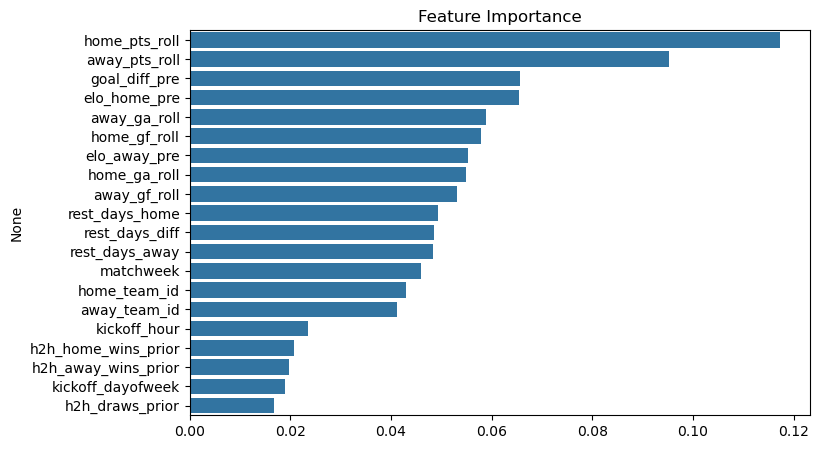

In [110]:
predict(m)